### Setup

In [1]:
from typing import List
from openai import OpenAI
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

# os.environ['OPENAI_API_KEY'] = "YOUR_OPENAI_API_KEY"


with open("qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

### Haystack

#### Setup

In [7]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.components.builders.prompt_builder import PromptBuilder

def get_haystack():
    document_store = InMemoryDocumentStore()
    prompt_template = """
    Given these documents, answer the question.
    Documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}
    Question: {{question}}
    Answer:
    """
    # Add documents to document store
    for doc in os.listdir("../paul_graham_essays"):
        with open(f"../paul_graham_essays/{doc}", "r") as f:
            content = f.read()
            document = Document(content=content)
            document_store.write_documents([document])


    retriever = InMemoryBM25Retriever(document_store=document_store, top_k=3)
    prompt_builder = PromptBuilder(template=prompt_template)
    llm = OpenAIGenerator(model="gpt-4-turbo-preview")

    rag_pipeline = Pipeline()
    rag_pipeline.add_component("retriever", retriever)
    rag_pipeline.add_component("prompt_builder", prompt_builder)
    rag_pipeline.add_component("llm", llm)
    rag_pipeline.connect("retriever", "prompt_builder.documents")
    rag_pipeline.connect("prompt_builder", "llm")
    return rag_pipeline

In [8]:
haystack_pipeline = get_haystack()

In [9]:
def get_haystack_response(query):
    haystack_response = haystack_pipeline.run(
        {
            "retriever": {"query": query},
            "prompt_builder": {"question": query},
        }
    )
    return haystack_response['llm']['replies'][0]

#### Testing

In [10]:

benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_haystack_response(benchmark_item.question))

Ranking by BM25...: 100%|██████████| 212/212 [00:00<00:00, 2287.18 docs/s]


According to Paul Graham, creating a technology hub requires the following key components:

1. The Right People: The presence of the right people is crucial for creating a technology hub. Graham emphasizes that you need a critical mass of both rich people (investors) and nerds (innovators and technical talent). These are the limiting reagents in the reaction that produces startups because they're present at the inception of startups. Other necessary elements and individuals will gravitate towards a hub once these essential groups are present.

2. Universities: Graham highlights the indispensable role of top-tier universities in creating a technology hub. Universities act as magnets, drawing the best and brightest minds from all over, which in turn, attracts more talent and resources. The innovation and ideas generated in this academic environment feed into the startup ecosystem.

3. Personality and Quality of Life: A city or area needs a certain personality to attract and retain the cr

##### Run through all the questions

In [11]:
raw_customgpt_responses = []
for x in tqdm(benchmark.items):
    raw_customgpt_responses.append(get_haystack_response(x.question))


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [04:46<00:00, 11.47s/it]


In [12]:
customgpt_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_customgpt_responses, benchmark.items)
]

In [13]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
customgpt_run = scorer.score_run(customgpt_responses)

Scoring responses: 100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


In [29]:
customgpt_run_df = run_to_dataframe(customgpt_run)
customgpt_run_df.to_csv("customgpt_run.csv", index=False)

In [33]:
customgpt_run

Run(overall_scores={'answer_similarity': 4.84}, run_data=[RunData(scores={'answer_similarity': 5.0}, reference_question="What realization did Paul Graham have about the value of reading books, even if he doesn't remember their details?", reference_answer="Paul Graham realized that the true value of reading books isn't necessarily in remembering all the details but in how those readings shape and train his mental model of the world. Even if the specific knowledge is forgotten over time, its impact on his understanding and perspective remains, enhancing his cognition and worldview. This insight helped him appreciate the enduring worth of reading beyond the immediate recall of facts.", llm_answer="Paul Graham realized that the value of reading books isn't diminished even if he doesn't remember their details because reading and experience shape his model of the world. Even if he forgets the specifics, the effect on his worldview persists. This realization helped him understand that the kno

In [30]:
customgpt_run_df

,reference_question,reference_answer,llm_answer,llm_context,answer_similarity
0,What realization did Paul Graham have about th...,Paul Graham realized that the true value of re...,Paul Graham realized that the value of reading...,[],5.0
1,Why does the author believe Twitter is conside...,The author believes Twitter is considered a si...,The author believes Twitter is considered a si...,[],5.0
2,What distinguishes an intentional moderate fro...,An intentional moderate chooses a position mid...,"According to Paul Graham, what distinguishes a...",[],5.0
3,What is the purpose of the patent pledge propo...,The purpose of the patent pledge proposed by P...,The purpose of the patent pledge proposed by P...,[],5.0
4,What main advantage does Paul Graham identify ...,Paul Graham identifies that the main advantage...,The main advantage Paul Graham identifies in u...,[],5.0
5,What are the three components of independent-m...,The three components of independent-mindedness...,The three components of independent-mindedness...,[],5.0
6,How does Paul Graham compare the RIAA and MPAA...,Paul Graham compares the RIAA and MPAA's accus...,Paul Graham compares the RIAA and MPAA's accus...,[],5.0
7,Why does Paul Graham argue that the concept of...,"Paul Graham argues that the concept of ""taste ...","Paul Graham argues that the concept of ""taste ...",[],5.0
8,"According to Paul Graham, why should programme...","According to Paul Graham, programmers should c...","According to Paul Graham, programmers should c...",[],5.0
9,What does Paul Graham argue is the main reason...,Paul Graham argues that the main reason for va...,Paul Graham argues that the main reason for va...,[],5.0


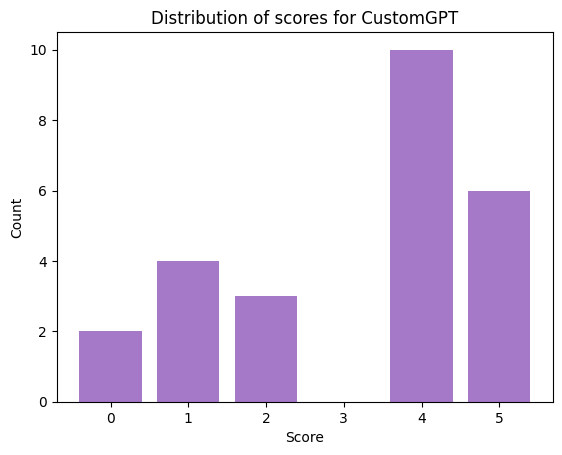

In [10]:
customgpt_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in customgpt_run.run_data])
category_counts = customgpt_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for CustomGPT')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

### OpenAI Rag Assistant

#### Setup

In [17]:
client = OpenAI()

In [20]:
def get_openai_rag_response(benchmarkItem: BenchmarkItem, assistant):
    prompt = benchmarkItem.question
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_retries = 10
    base = 0.1
    num_retries = 0
    try:
        while max_retries > 0:
            if max_retries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            if len(messages.data)>0 and len(messages.data[0].content)>0:
                response_message = messages.data[0].content[0].text.value
                if response_message != prompt and response_message.strip():
                    client.beta.threads.delete(thread.id)
                    return response_message
            time.sleep(base * (2 ** num_retries))
            num_retries += 1
            max_retries -= 1
    except Exception as e:
        print(e)
        client.beta.threads.delete(thread.id)
        raise e

#openai rag only supports a max of 20 files. So we just combine all essays into single file
def upload_essay():
    file_ids=[]
    with open("all_essays_in_single_file.txt", 'rb') as essay_file:
        file = client.files.create(
            file=essay_file,
            purpose='assistants'
        )
        file_ids.append(file.id)
    return file_ids

def create_assistant(file_ids):
    return client.beta.assistants.create(
        name=f"OpenAI Rag Test {len(file_ids)} Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
            "Use your knowledge base to best respond to questions. "
            "NO MATTER WHAT, DO NOT PULL INFORMATION FROM EXTERNAL KNOWLEDGE. ONLY USE YOUR OWN KNOWLEDGE BASE."
        ),
        model="gpt-4-turbo-preview",
        tools=[{"type": "retrieval"}],
        file_ids=file_ids
    )

def setup_assistant():
    file_ids = upload_essay()
    return create_assistant(file_ids)

# WARNING
# this deletes all files associated with your openai api key.
#def cleanup_files():
#    for f in client.files.list():
#        client.files.delete(f.id)
#        time.sleep(1)

#### Testing

In [21]:
assistant = setup_assistant()

In [22]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_openai_rag_response(benchmark_item, assistant))

According to Paul Graham, the key components necessary to create a technology hub include:

1. **Youth Appeal**: Technology hubs are usually started by young nerds, so it's crucial that the city appeals specifically to them. The cities need to feel young, which doesn't necessarily mean they have to be new but should be full of students or young people. Large populations of conservative or stodgy people are to be avoided as they could have too much momentum in the wrong direction for startups 【5†source】.

2. **Tolerance for Odd Ideas**: Startups often begin with concepts that seem a little crazy or unconventional. High-tech cities in the US are also the most liberal because liberal cities tolerate odd ideas, which are essential for startups. Conversely, towns known for being "solid" or representing "traditional values" are unlikely to succeed as startup hubs. This connection between technology and liberalism outlines the importance of a culturally open environment 【7:0†source】.

3. **An

##### Run through all the questions

In [23]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Assuming get_openai_rag_response and benchmark are defined

# Function to be executed by each thread
def process_item(x):
    return get_openai_rag_response(x, assistant)

# Number of threads to use, you can adjust this based on your system's capabilities
num_threads = 4

# Use ThreadPoolExecutor to parallelize the execution
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Prepare a list to hold results
    raw_openai_responses = list(tqdm(executor.map(process_item, benchmark.items), total=len(benchmark.items)))

# At this point, raw_openai_responses will be filled with the results


100%|██████████| 25/25 [04:52<00:00, 11.71s/it]


In [24]:
openai_responses = [
    LLMResponse(
        llm_answer=str(r), llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_openai_responses, benchmark.items)
]

In [25]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
openai_run = scorer.score_run(openai_responses, parallelism=5)

Scoring responses: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


In [32]:
openai_run

Run(overall_scores={'answer_similarity': 4.44}, run_data=[RunData(scores={'answer_similarity': 5.0}, reference_question="What realization did Paul Graham have about the value of reading books, even if he doesn't remember their details?", reference_answer="Paul Graham realized that the true value of reading books isn't necessarily in remembering all the details but in how those readings shape and train his mental model of the world. Even if the specific knowledge is forgotten over time, its impact on his understanding and perspective remains, enhancing his cognition and worldview. This insight helped him appreciate the enduring worth of reading beyond the immediate recall of facts.", llm_answer='Paul Graham\'s realization about the value of reading books, even if he doesn\'t remember their details, is deeply insightful. He observes that while the direct information from a book may be forgotten, the impact it has on one\'s mental models of the world remains. This effect is likened to com

In [26]:
openai_run_df = run_to_dataframe(openai_run)
openai_run_df.to_csv("openai_run.csv", index=False)

In [27]:
# Load csv
openai_run_df = pd.read_csv("openai_run.csv")

In [31]:
openai_run_df.describe()

,answer_similarity
count,25.000000
mean,4.440000
std,1.556706
min,0.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


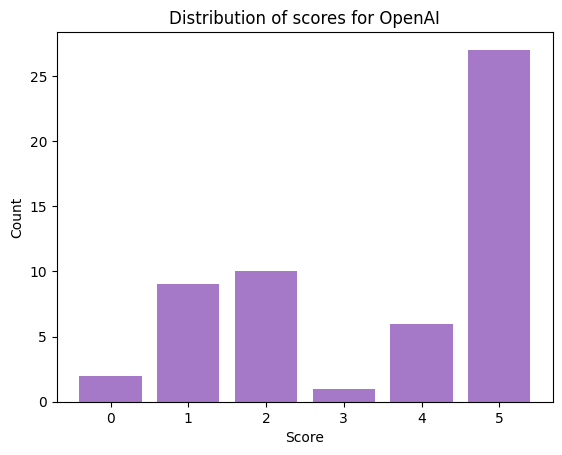

In [16]:
openai_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in openai_run.run_data])
category_counts = openai_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for OpenAI')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

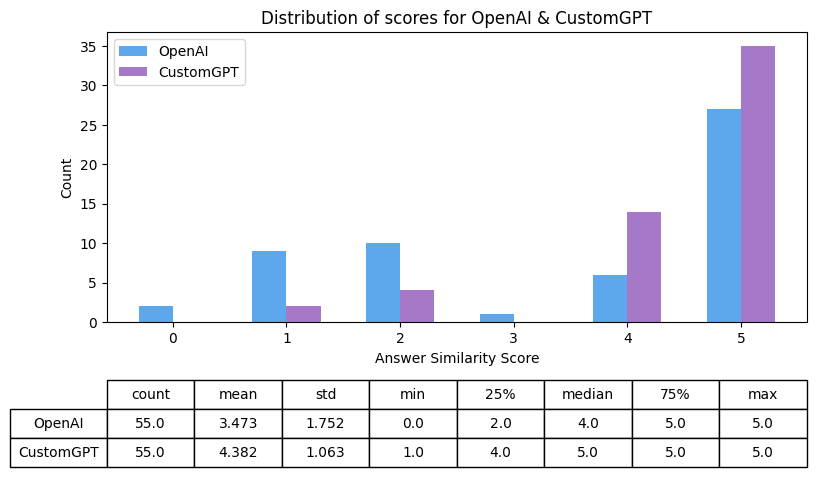

In [17]:
import matplotlib.pyplot as plt
import numpy as np

openai_run_df = pd.read_csv("openai_run.csv")
customgpt_run_df = pd.read_csv("customgpt_run.csv")

combined_scores = pd.DataFrame({
    "OpenAI": list(openai_run_df["answer_similarity"]),
    "CustomGPT": list(customgpt_run_df["answer_similarity"])
})

# Position of bars on x-axis
ind = np.arange(6)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar
width = 0.3

openai_counts = combined_scores["OpenAI"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(openai_counts.index, openai_counts.values, width, label="OpenAI", color="#5EA7EC")

customgpt_counts = combined_scores["CustomGPT"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(customgpt_counts.index + width, customgpt_counts.values, width, label="CustomGPT", color="#A679C8")

plt.title('Distribution of scores for OpenAI & CustomGPT')
plt.xlabel('Answer Similarity Score')
plt.ylabel('Count')

# Remove all scores except whole numbers
plt.xticks(ind + width / 2, range(0, 6, 1))

plt.legend(loc='best')

# Rounding the descriptive statistics to 3 significant figures
statistics_df = combined_scores.describe()
# Change 50% to 50% (median)
statistics_df = statistics_df.rename(index={'50%': 'median'})
rounded_statistics_df = statistics_df.round(3)

# Transposing the descriptive statistics table for horizontal display
rounded_statistics_df = rounded_statistics_df.T

# Adding the table below the histogram
table = plt.table(cellText=rounded_statistics_df.values,
                  colWidths=[0.1] * len(rounded_statistics_df.columns),
                  rowLabels=rounded_statistics_df.index,
                  colLabels=rounded_statistics_df.columns,
                  cellLoc = 'center', rowLoc = 'center',
                  loc='bottom', bbox=[0.0, -0.5, 1.0, 0.3])

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.savefig("openai_v_customgpt.png", facecolor='white', bbox_inches='tight')

plt.show()